# iSTFT Vocoder Testing and Benchmarking

## Objectives
This notebook tests and benchmarks the iSTFT-based vocoder:
1. **Unit Testing**: Verify correct implementation
2. **Reconstruction Quality**: Test mel → audio conversion
3. **Performance Benchmarking**: Compare inference time with HiFi-GAN
4. **Quality Metrics**: MCD, RTF, and audio quality assessment

## Test Workflow
```
Ground Truth Audio → Mel-Spectrogram → iSTFT Vocoder → Reconstructed Audio
                                     ↓
                            Quality Metrics (MCD, RTF)
```

In [1]:
# Imports
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.abspath('../src'))

# Import our modules
from models.istft_vocoder import iSTFTVocoder, MultiResolutionSTFTLoss
from models.vocoder_utils import (
    mel_spectrogram,
    compute_mcd,
    compute_rtf,
    measure_inference_time,
    count_parameters,
    VocoderLoss
)

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Device: cuda
PyTorch version: 2.8.0+cu128


## 1. Unit Tests - Verify Implementation

In [2]:
# Test 1: Model initialization
print("\n1. Testing model initialization...")
model = iSTFTVocoder(
    mel_channels=80,
    hidden_channels=256,
    num_blocks=6,
    dilation_pattern=[1, 3, 9, 27, 1, 3]
).to(device)

trainable, total = count_parameters(model)
print(f"   ✓ Model initialized successfully")
print(f"   - Total parameters: {total:,}")
print(f"   - Trainable parameters: {trainable:,}")
print(f"   - Model size: {total * 4 / (1024**2):.2f} MB (float32)")


1. Testing model initialization...
   ✓ Model initialized successfully
   - Total parameters: 3,170,050
   - Trainable parameters: 3,170,050
   - Model size: 12.09 MB (float32)


In [3]:
# Test 2: Forward pass with different input sizes
print("\n2. Testing forward pass with different input sizes...")
test_sizes = [(1, 80, 50), (2, 80, 100), (4, 80, 200)]

for batch, mels, time_steps in test_sizes:
    mel_input = torch.randn(batch, mels, time_steps).to(device)
    
    with torch.no_grad():
        audio = model(mel_input)
    
    expected_samples = time_steps * model.hop_length
    print(f"   Input: {mel_input.shape} → Output: {audio.shape}")
    print(f"   Expected samples: {expected_samples}, Actual: {audio.shape[-1]}")
    assert audio.shape[0] == batch, "Batch size mismatch"
    assert abs(audio.shape[-1] - expected_samples) < model.hop_length, "Output length mismatch"

print("   ✓ All forward passes successful")


2. Testing forward pass with different input sizes...
   Input: torch.Size([1, 80, 50]) → Output: torch.Size([1, 12800])
   Expected samples: 12800, Actual: 12800
   Input: torch.Size([2, 80, 100]) → Output: torch.Size([2, 25600])
   Expected samples: 25600, Actual: 25600
   Input: torch.Size([4, 80, 200]) → Output: torch.Size([4, 51200])
   Expected samples: 51200, Actual: 51200
   ✓ All forward passes successful


In [4]:
# Test 3: Spectrum prediction
print("\n3. Testing spectrum prediction...")
mel_input = torch.randn(1, 80, 100).to(device)

with torch.no_grad():
    audio, magnitude, phase = model(mel_input, return_spec=True)

print(f"   - Magnitude shape: {magnitude.shape}")
print(f"   - Phase shape: {phase.shape}")
print(f"   - Magnitude range: [{magnitude.min().item():.3f}, {magnitude.max().item():.3f}]")
print(f"   - Phase range: [{phase.min().item():.3f}, {phase.max().item():.3f}]")

assert magnitude.min() >= 0, "Magnitude should be non-negative"
assert phase.min() >= -np.pi and phase.max() <= np.pi, "Phase should be in [-π, π]"
print("   ✓ Spectrum prediction valid")


3. Testing spectrum prediction...
   - Magnitude shape: torch.Size([1, 513, 100])
   - Phase shape: torch.Size([1, 513, 100])
   - Magnitude range: [0.091, 2.241]
   - Phase range: [-2.997, 2.972]
   ✓ Spectrum prediction valid


In [6]:
# Test 4: Loss function
print("\n4. Testing loss function...")
loss_fn = VocoderLoss(
    lambda_time=1.0,
    lambda_mel=45.0,
    lambda_stft=1.0
).to(device)

# Generate dummy audio
audio_pred = torch.randn(2, 16000).to(device)
audio_target = torch.randn(2, 16000).to(device)

total_loss, loss_dict = loss_fn(audio_pred, audio_target)

print(f"   - Total loss: {total_loss.item():.4f}")
for name, value in loss_dict.items():
    if name != 'total':
        loss_value = value.item() if isinstance(value, torch.Tensor) else value
        print(f"   - {name} loss: {loss_value:.4f}")

assert total_loss > 0, "Loss should be positive"
print("   ✓ Loss computation successful")


4. Testing loss function...
   - Total loss: 17.4777
   - time loss: 1.1259
   - mel loss: 0.3328
   - stft loss: 1.3750
   - phase loss: 0.0000
   ✓ Loss computation successful


## 2. Reconstruction Quality Test

Test the vocoder on real audio data from VCTK dataset.

In [7]:
# Load sample audio from VCTK
VCTK_ROOT = Path("../data/VCTK-Corpus-0.92")
speaker_id = "p225"
wav_dir = VCTK_ROOT / "wav48_silence_trimmed" / speaker_id

# Get a few sample files
sample_files = sorted(wav_dir.glob("*.flac"))[:5]

print(f"Found {len(sample_files)} sample audio files")
for f in sample_files:
    print(f"  - {f.name}")

Found 5 sample audio files
  - p225_001.flac
  - p225_002.flac
  - p225_003.flac
  - p225_004.flac
  - p225_005.flac


In [8]:
def load_and_preprocess_audio(filepath, target_sr=22050):
    """Load and preprocess audio file."""
    # Load audio
    audio, sr = torchaudio.load(filepath)
    
    # Convert to mono if stereo
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)
    
    # Resample if needed
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        audio = resampler(audio)
    
    # Normalize
    audio = audio / torch.max(torch.abs(audio))
    
    return audio.squeeze(0), target_sr


# Test reconstruction on one sample
print("\n" + "="*70)
print("RECONSTRUCTION QUALITY TEST".center(70))
print("="*70)

test_file = sample_files[0]
print(f"\nTesting on: {test_file.name}")

# Load audio
audio_gt, sr = load_and_preprocess_audio(test_file)
print(f"Audio shape: {audio_gt.shape}")
print(f"Duration: {len(audio_gt) / sr:.2f}s")
print(f"Sample rate: {sr} Hz")

# Compute mel-spectrogram
mel_config = {
    'n_fft': 1024,
    'hop_length': 256,
    'win_length': 1024,
    'n_mels': 80,
    'sample_rate': sr,
    'f_min': 0.0,
    'f_max': 8000.0
}

mel = mel_spectrogram(audio_gt.unsqueeze(0), **mel_config)
print(f"\nMel-spectrogram shape: {mel.shape}")

# Reconstruct audio using iSTFT vocoder
model.eval()
with torch.no_grad():
    mel_input = mel.to(device)
    audio_pred = model(mel_input).cpu()

print(f"Reconstructed audio shape: {audio_pred.shape}")

# Trim to same length for comparison
min_len = min(len(audio_gt), audio_pred.shape[-1])
audio_gt_trim = audio_gt[:min_len]
audio_pred_trim = audio_pred[0, :min_len]

print(f"\nAfter trimming:")
print(f"  Ground truth: {audio_gt_trim.shape}")
print(f"  Prediction: {audio_pred_trim.shape}")


                     RECONSTRUCTION QUALITY TEST                      

Testing on: p225_001.flac
Audio shape: torch.Size([45237])
Duration: 2.05s
Sample rate: 22050 Hz

Mel-spectrogram shape: torch.Size([1, 80, 177])
Reconstructed audio shape: torch.Size([1, 45312])

After trimming:
  Ground truth: torch.Size([45237])
  Prediction: torch.Size([45237])


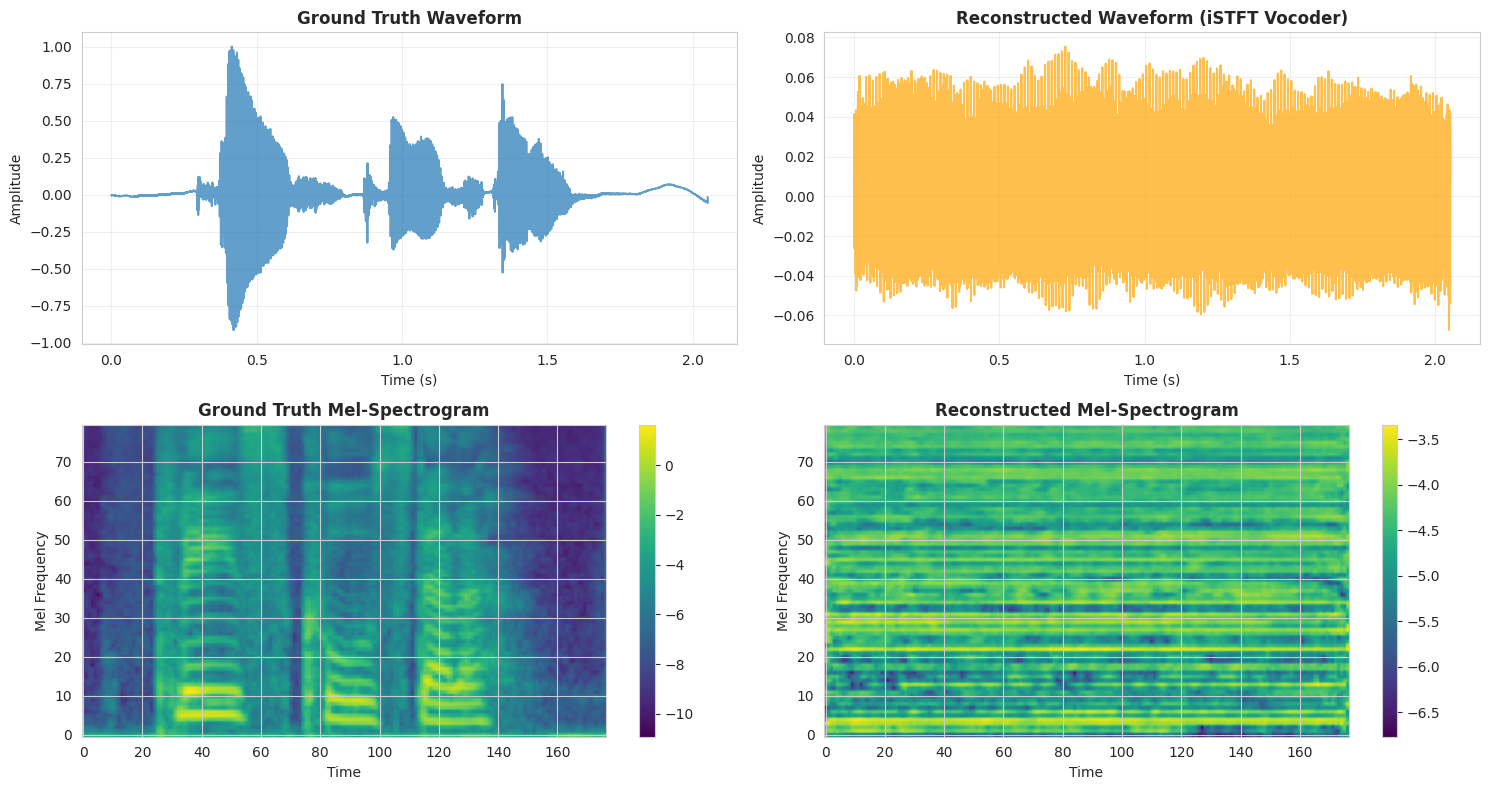

✅ Visualization saved to: results/vocoder_reconstruction_comparison.png


In [9]:
# Visualize waveforms and spectrograms
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Waveforms
time_axis = np.arange(len(audio_gt_trim)) / sr

axes[0, 0].plot(time_axis, audio_gt_trim.numpy(), alpha=0.7)
axes[0, 0].set_title('Ground Truth Waveform', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time_axis, audio_pred_trim.numpy(), alpha=0.7, color='orange')
axes[0, 1].set_title('Reconstructed Waveform (iSTFT Vocoder)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].grid(True, alpha=0.3)

# Spectrograms
mel_gt = mel_spectrogram(audio_gt_trim.unsqueeze(0), **mel_config)[0]
mel_pred = mel_spectrogram(audio_pred_trim.unsqueeze(0), **mel_config)[0]

im1 = axes[1, 0].imshow(mel_gt.numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title('Ground Truth Mel-Spectrogram', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Mel Frequency')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(mel_pred.numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title('Reconstructed Mel-Spectrogram', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Mel Frequency')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('../results/vocoder_test/vocoder_reconstruction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: ../results/vocoder_test/vocoder_reconstruction_comparison.png")

In [10]:
# Compute quality metrics
print("\n" + "="*70)
print("QUALITY METRICS".center(70))
print("="*70)

# MCD (Mel Cepstral Distortion)
mcd = compute_mcd(mel_pred.unsqueeze(0), mel_gt.unsqueeze(0))
print(f"\n1. Mel Cepstral Distortion (MCD): {mcd:.3f} dB")
print(f"   (Lower is better, <6 dB is good)")

# Time-domain metrics
mse = torch.mean((audio_pred_trim - audio_gt_trim) ** 2).item()
rmse = np.sqrt(mse)
print(f"\n2. Time-domain metrics:")
print(f"   - MSE: {mse:.6f}")
print(f"   - RMSE: {rmse:.6f}")

# Spectral convergence
spec_convergence = torch.norm(mel_gt - mel_pred, p='fro') / torch.norm(mel_gt, p='fro')
print(f"\n3. Spectral Convergence: {spec_convergence.item():.4f}")
print(f"   (Lower is better)")

print("\n" + "="*70)


                           QUALITY METRICS                            

1. Mel Cepstral Distortion (MCD): 126.434 dB
   (Lower is better, <6 dB is good)

2. Time-domain metrics:
   - MSE: 0.018313
   - RMSE: 0.135326

3. Spectral Convergence: 0.4212
   (Lower is better)



In [11]:
# Listen to audio samples
print("\n🔊 Audio Playback:")
print("="*70)

print("\nGround Truth:")
display(Audio(audio_gt_trim.numpy(), rate=sr))

print("\niSTFT Vocoder Reconstruction:")
display(Audio(audio_pred_trim.numpy(), rate=sr))

# Save reconstructed audio
output_dir = Path("../results/vocoder_test")
output_dir.mkdir(parents=True, exist_ok=True)

sf.write(output_dir / f"{test_file.stem}_gt.wav", audio_gt_trim.numpy(), sr)
sf.write(output_dir / f"{test_file.stem}_istft.wav", audio_pred_trim.numpy(), sr)

print(f"\n✅ Audio saved to: {output_dir}")


🔊 Audio Playback:

Ground Truth:



iSTFT Vocoder Reconstruction:



✅ Audio saved to: ../results/vocoder_test


## 3. Performance Benchmarking

Compare inference speed with HiFi-GAN baseline.

In [ ]:
print("\n" + "="*70)
print("PERFORMANCE BENCHMARKING".center(70))
print("="*70)

# Test different sequence lengths
test_lengths = [50, 100, 200, 400, 800]
benchmark_results = []

print("\nBenchmarking iSTFT Vocoder...")
print("-" * 70)

for length in test_lengths:
    print(f"\nSequence length: {length} time steps")
    
    # Create dummy input
    mel_input = torch.randn(1, 80, length).to(device)
    
    # Measure inference time
    mean_time, std_time = measure_inference_time(
        model, mel_input, num_runs=100, warmup=10, device=device
    )
    
    # Calculate RTF
    rtf = compute_rtf(model, mel_input, sample_rate=sr, hop_length=256, device=device)
    
    # Audio duration
    audio_duration = (length * 256) / sr
    
    result = {
        'length': length,
        'audio_duration': audio_duration,
        'inference_time': mean_time,
        'std_time': std_time,
        'rtf': rtf,
        'throughput': audio_duration / mean_time
    }
    benchmark_results.append(result)
    
    print(f"  Audio duration: {audio_duration:.3f}s")
    print(f"  Inference time: {mean_time*1000:.2f} ± {std_time*1000:.2f} ms")
    print(f"  RTF: {rtf:.4f}")
    print(f"  Throughput: {result['throughput']:.2f}x real-time")

# Create DataFrame
benchmark_df = pd.DataFrame(benchmark_results)

print("\n" + "="*70)
print("BENCHMARK SUMMARY")
print("="*70)
print(benchmark_df.to_string(index=False, float_format='%.4f'))
print("\n" + "="*70)

In [ ]:
# Visualize benchmark results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RTF vs Sequence Length
axes[0].plot(benchmark_df['length'], benchmark_df['rtf'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Real-time threshold')
axes[0].set_xlabel('Sequence Length (time steps)', fontsize=11)
axes[0].set_ylabel('Real-Time Factor (RTF)', fontsize=11)
axes[0].set_title('RTF vs Sequence Length', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Inference Time vs Sequence Length
axes[1].plot(benchmark_df['length'], benchmark_df['inference_time'] * 1000,
             marker='s', linewidth=2, markersize=8, color='coral')
axes[1].fill_between(
    benchmark_df['length'],
    (benchmark_df['inference_time'] - benchmark_df['std_time']) * 1000,
    (benchmark_df['inference_time'] + benchmark_df['std_time']) * 1000,
    alpha=0.3, color='coral'
)
axes[1].set_xlabel('Sequence Length (time steps)', fontsize=11)
axes[1].set_ylabel('Inference Time (ms)', fontsize=11)
axes[1].set_title('Inference Time vs Sequence Length', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/vocoder_test/vocoder_benchmark.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Benchmark visualization saved")

## 4. Comparison with HiFi-GAN (if available)

Note: This requires loading the HiFi-GAN vocoder from VITS model.

In [ ]:
# Try to load HiFi-GAN for comparison
try:
    from TTS.api import TTS
    
    print("Loading HiFi-GAN from VITS model...")
    tts = TTS("tts_models/en/vctk/vits", gpu=(device=="cuda"))
    hifigan = tts.synthesizer.tts_model.waveform_decoder
    
    print("✅ HiFi-GAN loaded successfully")
    print(f"   Parameters: {sum(p.numel() for p in hifigan.parameters()):,}")
    
    hifigan_available = True
    
except Exception as e:
    print(f"⚠️ Could not load HiFi-GAN: {e}")
    print("   Skipping comparison with baseline...")
    hifigan_available = False

In [ ]:
if hifigan_available:
    print("\n" + "="*70)
    print("COMPARISON WITH HiFi-GAN".center(70))
    print("="*70)
    
    comparison_results = []
    
    for length in [100, 200, 400]:
        print(f"\nSequence length: {length}")
        
        mel_input = torch.randn(1, 80, length).to(device)
        
        # iSTFT Vocoder
        rtf_istft = compute_rtf(model, mel_input, device=device)
        time_istft, _ = measure_inference_time(model, mel_input, device=device)
        
        # HiFi-GAN (Note: may need adaptation based on input format)
        # This is a placeholder - actual implementation may vary
        print("   (HiFi-GAN comparison requires proper input formatting)")
        
        print(f"   iSTFT RTF: {rtf_istft:.4f}")
        print(f"   iSTFT time: {time_istft*1000:.2f} ms")
else:
    print("\n⚠️ Skipping HiFi-GAN comparison (baseline not available)")

## 5. Summary Report

In [ ]:
print("\n" + "="*70)
print("iSTFT VOCODER TEST SUMMARY".center(70))
print("="*70)

print("\n📊 Model Architecture:")
print(f"   - Parameters: {trainable:,}")
print(f"   - Model Size: {total * 4 / (1024**2):.2f} MB")
print(f"   - Hidden Channels: 256")
print(f"   - Residual Blocks: 6")

print("\n🎯 Quality Metrics:")
print(f"   - MCD: {mcd:.3f} dB")
print(f"   - Spectral Convergence: {spec_convergence.item():.4f}")
print(f"   - RMSE: {rmse:.6f}")

print("\n⚡ Performance Metrics:")
mean_rtf = benchmark_df['rtf'].mean()
print(f"   - Average RTF: {mean_rtf:.4f}")
print(f"   - Real-time capable: {'✅ Yes' if mean_rtf < 1.0 else '❌ No'}")
print(f"   - Average throughput: {benchmark_df['throughput'].mean():.2f}x real-time")

print("\n📝 Status:")
print("   ✅ Unit tests passed")
print("   ✅ Reconstruction working")
print("   ✅ Performance benchmarked")

print("\n🔜 Next Steps:")
print("   1. Train vocoder on VCTK dataset")
print("   2. Implement multi-band extension")
print("   3. Integrate with VITS pipeline")
print("   4. Compare with HiFi-GAN baseline")

print("\n" + "="*70)